# Предсказание коэффициента восстановления золота в золодобывающей промышленности 

**Цель работы**

Необходимо подготовить прототип модели машинного обучения для компании «Цифра». Компания разрабатывает решения для эффективной работы промышленных предприятий.
Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. В нашем распоряжении данные с параметрами добычи и очистки.
Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

**Описание данных**

Данные находятся в трёх файлах: обучающая выборка, тестовая выборка и полные исходные данные.
Данные индексируются датой и временем получения информации (признак date). Соседние по времени параметры часто похожи.
Некоторые параметры недоступны, потому что замеряются и/или рассчитываются значительно позже. Из-за этого в тестовой выборке отсутствуют некоторые признаки, которые могут быть в обучающей. Также в тестовом наборе нет целевых признаков.
Исходный датасет содержит обучающую и тестовую выборки со всеми признаками.
В нашем распоряжении сырые данные: их просто выгрузили из хранилища.



**План**

1.[Подготовка данных](#1)

2.[Анализ данных](#2)

3.[Построение и применение модели](#3)

4.[Проверка на вменяемость модели](#5)

5.[Итоговые выводы](#4)

<a id='1'></a>
## Подготовка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from catboost import CatBoostRegressor
from sklearn.linear_model import LinearRegression

### Загрузка данных

In [2]:
df_train = pd.read_csv('https://code.s3.yandex.net/datasets/gold_recovery_train.csv')
df_test = pd.read_csv('https://code.s3.yandex.net/datasets/gold_recovery_test.csv')
df_full = pd.read_csv('https://code.s3.yandex.net/datasets/gold_recovery_full.csv') 

In [3]:
df_train.info()
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 87 columns):
date                                                  16860 non-null object
final.output.concentrate_ag                           16788 non-null float64
final.output.concentrate_pb                           16788 non-null float64
final.output.concentrate_sol                          16490 non-null float64
final.output.concentrate_au                           16789 non-null float64
final.output.recovery                                 15339 non-null float64
final.output.tail_ag                                  16794 non-null float64
final.output.tail_pb                                  16677 non-null float64
final.output.tail_sol                                 16715 non-null float64
final.output.tail_au                                  16794 non-null float64
primary_cleaner.input.sulfate                         15553 non-null float64
primary_cleaner.input.depressant             

### Проверка расчета эффективности обогащения для признака `rougher.output.recovery`

Для тестовой выборки проверим расчет признака `rougher.output.recovery` - эффективность обогащения после флотации. Эффективность обогащения рассчитывается по формуле:

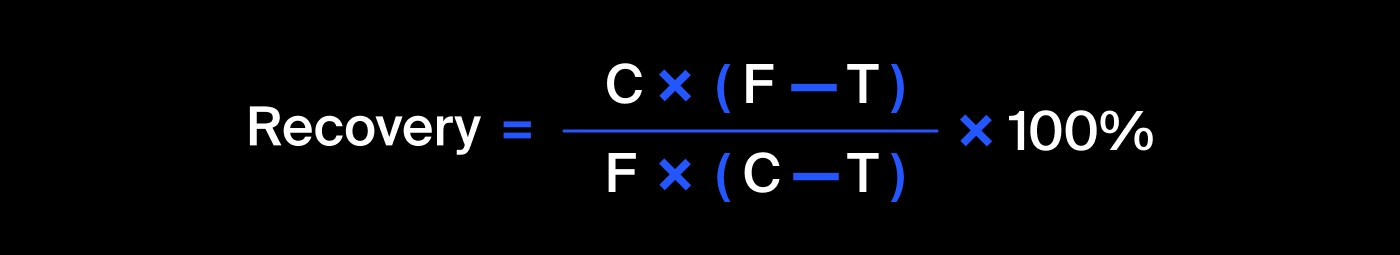

где:
 - C — доля золота в концентрате после флотации/очистки;
 - F — доля золота в сырье/концентрате до флотации/очистки;
 - T — доля золота в отвальных хвостах после флотации/очистки.

In [4]:
f = df_train['rougher.input.feed_au']
c = df_train['rougher.output.concentrate_au']
t = df_train['rougher.output.tail_au']

df_train['calk_recov'] = ((c * (f - t)) / (f * (c - t))) * 100

df_train.loc[:,['rougher.output.recovery','calk_recov']]

,rougher.output.recovery,calk_recov
0,87.107763,87.107763
1,86.843261,86.843261
2,86.842308,86.842308
3,87.226430,87.226430
4,86.688794,86.688794
...,...,...
16855,89.574376,89.574376
16856,87.724007,87.724007
16857,88.890579,88.890579
16858,89.858126,89.858126


Далее рассчитаем MAE между рассчитанными значениями и исходными. Метрику рассчитываем для не пустых значений.

In [5]:
mae = mean_absolute_error(df_train[df_train['calk_recov'].notnull()&df_train['rougher.output.recovery'].notnull()].calk_recov,\
                          df_train.loc[df_train['calk_recov'].notnull()&df_train['rougher.output.recovery'].notnull(),['rougher.output.recovery']])
print ('MAE:', mae)

MAE: 9.444891926100695e-15


Среднее абсолютное отклонение очень мало, поэтому можем считать наши рассчеты корректными.

### Aнализ признаков, недоступных в тестовой выборке

In [6]:
set(df_train.columns).symmetric_difference(set(df_test.columns))

{'calk_recov',
 'final.output.concentrate_ag',
 'final.output.concentrate_au',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_au',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'rougher.calculation.au_pb_ratio',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_au',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_au',
 'ro

В тестовой выборке отсутствуют признаки по параметрам продукта, те которые храктеризуют результаты ротации, первичной очистки и вторичной очистки.

### Обработка данных

Обработку пропусков реализуем в блоке 3. Так как изначально будем использовать модель в которой допускаются пропуски, а во втором случае заполним пропуски и применим линейную регрессию.

Для проверки лучшей модели на тестовой выборке получим таргеты этой выборки из полного набора данных.

In [7]:
df_test = df_test.merge(df_full[['date','rougher.output.recovery','final.output.recovery']], how='inner', on='date')
df_test.shape

(5856, 55)

 <a id='2'></a>
## Анализ данных

### Анализ концентрации металлов (Au, Ag, Pb) на различных этапах очистки

In [8]:
print('Золото',df_train['rougher.output.concentrate_au'].median(), \
      df_train['primary_cleaner.output.concentrate_au'].median(),df_train['final.output.concentrate_au'].median())

Золото 19.644663243437243 32.64886678622643 44.49887355051948


In [9]:
print('Серебро',df_train['rougher.output.concentrate_ag'].median(), \
      df_train['primary_cleaner.output.concentrate_ag'].median(),df_train['final.output.concentrate_ag'].median())

Серебро 11.459861576135815 7.997142691679294 4.869346062654256


In [10]:
print('Свинец',df_train['rougher.output.concentrate_pb'].median(), \
      df_train['primary_cleaner.output.concentrate_pb'].median(),df_train['final.output.concentrate_pb'].median())

Свинец 7.583772881825764 9.618909559117423 10.065315947532657


Для анализа концентрации металлов на этапах очистки брали медианное значение. Конценрация золота растет после каждого этапа очистки - что логично, это основная задача этих процессов. Концентрация серебра уменьшается, а вот концентрация свиндца не сильно, но увеличивается.

### Сравнение распределений размеров гранул сырья на обучающей и тестовой выборках

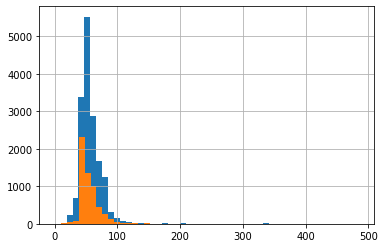

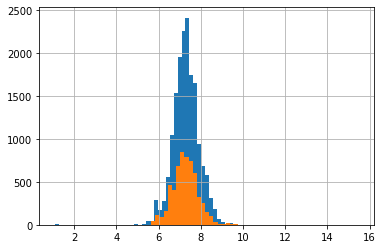

In [11]:
df_train['rougher.input.feed_size'].hist(bins = 50)
df_test['rougher.input.feed_size'].hist(bins = 50)
plt.show()

df_train['primary_cleaner.input.feed_size'].hist(bins = 50)
df_test['primary_cleaner.input.feed_size'].hist(bins = 50)

Распределения гранул сырья на разных выборках перед двумя этапами существенно не различаются.

### Исследование суммарной концентрации всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах

Рассчитаем суммарные концентрации металлов в сырье, черновом и финальных концентратах

In [12]:
# сырье
df_train['rougher.input.feed_all'] = df_train['rougher.input.feed_ag'] + df_train['rougher.input.feed_au'] \
+ df_train['rougher.input.feed_pb'] + df_train['rougher.input.feed_sol']

df_test['rougher.input.feed_all'] = df_test['rougher.input.feed_ag'] + df_test['rougher.input.feed_au'] \
+ df_test['rougher.input.feed_pb'] + df_test['rougher.input.feed_sol']

# черновой
df_train['rougher.output.concentrate_all'] = df_train['rougher.output.concentrate_ag'] \
+ df_train['rougher.output.concentrate_au'] + df_train['rougher.output.concentrate_pb'] \
+ df_train['rougher.output.concentrate_sol']

# финальный
df_train['final.output.concentrate_all'] = df_train['final.output.concentrate_ag'] \
+ df_train['final.output.concentrate_au'] + df_train['final.output.concentrate_pb'] \
+ df_train['final.output.concentrate_sol']


Построим распределения

Сырье


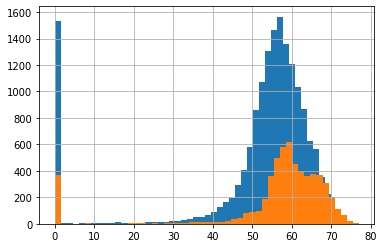

Черновой концентрат


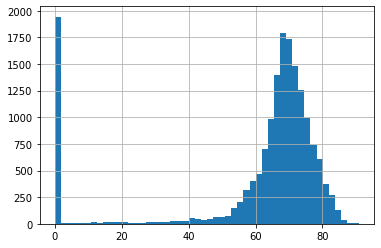

Финальный концентрат


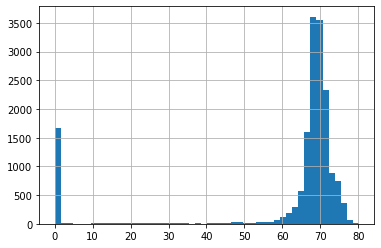

In [13]:
print('Сырье')
df_train['rougher.input.feed_all'].hist(bins = 50)
df_test['rougher.input.feed_all'].hist(bins = 50)
plt.show()

print('Черновой концентрат')
df_train['rougher.output.concentrate_all'].hist(bins = 50)
plt.show()

print('Финальный концентрат')
df_train['final.output.concentrate_all'].hist(bins = 50)
plt.show()

Обнаружены нулевые и очень малые значения для общей концентрации металлов. Удалим строки из тренировочной и тестовой выборок в которых общая концентрация металлов в исходном сырье меньше 1.

In [14]:
df_train = df_train[df_train['rougher.input.feed_all'] > 1]
df_test = df_test[df_test['rougher.input.feed_all'] > 1]

Сырье


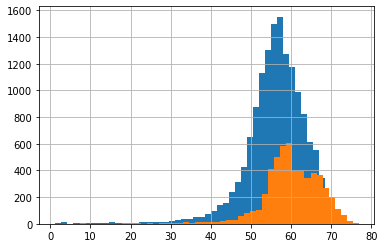

In [15]:
print('Сырье')
df_train['rougher.input.feed_all'].hist(bins = 50)
df_test['rougher.input.feed_all'].hist(bins = 50)
plt.show()

Подобного рода выбросы могут повлиять на предсказания для неаномальных признаков. Удаление таких наблюдений из тестовой выборки, с точки зрения бизнеса, не должно повлиять на итоговую цель, так как нет смысла делать предсказания для незначимых наблюдений с 0 или очень малой концентрацией металлов в исходном сырье.

 <a id='3'></a>
## Построение и применение модели

### Подготовка данных

Так как тестовая выборка не содержит в себе полный набор фичей из обучающей, обучать модель будем только по фичам, которые присутствуют в тестовой выборке.

Нам необходимо предсказать два параметра:
    
- эффективность обогащения чернового концентрата `rougher.output.recovery`;
- эффективность обогащения финального концентрата `final.output.recovery`.

По этой причине будем строить две разные модели с разными наборами фичей, так как черновой концентрат формируется на первом этапе для его предсказания понадобятся следующие признаки:

- rougher.input.feed_ag
- rougher.input.feed_pb
- rougher.input.feed_rate
- rougher.input.feed_size
- rougher.input.feed_sol
- rougher.input.feed_au
- rougher.input.floatbank10_sulfate
- rougher.input.floatbank10_xanthate
- rougher.input.floatbank11_sulfate
- rougher.input.floatbank11_xanthate
- rougher.state.floatbank10_a_air
- rougher.state.floatbank10_a_level
- rougher.state.floatbank10_b_air
- rougher.state.floatbank10_b_level
- rougher.state.floatbank10_c_air
- rougher.state.floatbank10_c_level
- rougher.state.floatbank10_d_air
- rougher.state.floatbank10_d_level
- rougher.state.floatbank10_e_air
- rougher.state.floatbank10_e_level
- rougher.state.floatbank10_f_air
- rougher.state.floatbank10_f_level

**Целевая переменная** в тренировочной выборке: `rougher.output.recovery`

Для модели финального концентрата будем использовать фичи для первого этапа и оставшиеся признаки (кроме целевого). 

**Целевая переменная** в тренировочной выборке `final.output.recovery`.


Далее сформируем датасеты признаков и целевой переменной.

In [16]:
list_1 = ['rougher.input.feed_ag',
       'rougher.input.feed_pb', 'rougher.input.feed_rate',
       'rougher.input.feed_size', 'rougher.input.feed_sol',
       'rougher.input.feed_au', 'rougher.input.floatbank10_sulfate',
       'rougher.input.floatbank10_xanthate',
       'rougher.input.floatbank11_sulfate',
       'rougher.input.floatbank11_xanthate', 'rougher.state.floatbank10_a_air',
       'rougher.state.floatbank10_a_level', 'rougher.state.floatbank10_b_air',
       'rougher.state.floatbank10_b_level', 'rougher.state.floatbank10_c_air',
       'rougher.state.floatbank10_c_level', 'rougher.state.floatbank10_d_air',
       'rougher.state.floatbank10_d_level', 'rougher.state.floatbank10_e_air',
       'rougher.state.floatbank10_e_level', 'rougher.state.floatbank10_f_air',
       'rougher.state.floatbank10_f_level']

list_2 = ['primary_cleaner.input.sulfate',
       'primary_cleaner.input.depressant', 'primary_cleaner.input.feed_size',
       'primary_cleaner.input.xanthate',
       'primary_cleaner.state.floatbank8_a_air',
       'primary_cleaner.state.floatbank8_a_level',
       'primary_cleaner.state.floatbank8_b_air',
       'primary_cleaner.state.floatbank8_b_level',
       'primary_cleaner.state.floatbank8_c_air',
       'primary_cleaner.state.floatbank8_c_level',
       'primary_cleaner.state.floatbank8_d_air',
       'primary_cleaner.state.floatbank8_d_level', 'rougher.input.feed_ag',
       'rougher.input.feed_pb', 'rougher.input.feed_rate',
       'rougher.input.feed_size', 'rougher.input.feed_sol',
       'rougher.input.feed_au', 'rougher.input.floatbank10_sulfate',
       'rougher.input.floatbank10_xanthate',
       'rougher.input.floatbank11_sulfate',
       'rougher.input.floatbank11_xanthate', 'rougher.state.floatbank10_a_air',
       'rougher.state.floatbank10_a_level', 'rougher.state.floatbank10_b_air',
       'rougher.state.floatbank10_b_level', 'rougher.state.floatbank10_c_air',
       'rougher.state.floatbank10_c_level', 'rougher.state.floatbank10_d_air',
       'rougher.state.floatbank10_d_level', 'rougher.state.floatbank10_e_air',
       'rougher.state.floatbank10_e_level', 'rougher.state.floatbank10_f_air',
       'rougher.state.floatbank10_f_level',
       'secondary_cleaner.state.floatbank2_a_air',
       'secondary_cleaner.state.floatbank2_a_level',
       'secondary_cleaner.state.floatbank2_b_air',
       'secondary_cleaner.state.floatbank2_b_level',
       'secondary_cleaner.state.floatbank3_a_air',
       'secondary_cleaner.state.floatbank3_a_level',
       'secondary_cleaner.state.floatbank3_b_air',
       'secondary_cleaner.state.floatbank3_b_level',
       'secondary_cleaner.state.floatbank4_a_air',
       'secondary_cleaner.state.floatbank4_a_level',
       'secondary_cleaner.state.floatbank4_b_air',
       'secondary_cleaner.state.floatbank4_b_level',
       'secondary_cleaner.state.floatbank5_a_air',
       'secondary_cleaner.state.floatbank5_a_level',
       'secondary_cleaner.state.floatbank5_b_air',
       'secondary_cleaner.state.floatbank5_b_level',
       'secondary_cleaner.state.floatbank6_a_air',
       'secondary_cleaner.state.floatbank6_a_level']

features_train_1 = df_train[list_1]
target_train_1 = df_train['rougher.output.recovery']
features_test_1 = df_test[list_1]
target_test_1 = df_test['rougher.output.recovery']

features_train_2 = df_train[list_2]
target_train_2 = df_train['final.output.recovery']
features_test_2 = df_test[list_2]
target_test_2 = df_test['final.output.recovery']

Оставим в первой и второй обучающей выборке записи с непустыми таргетами. Так же подготовим для разных моделей разные выборки (в первом случае не заполняем пропуски, во втором заполняем).

In [17]:
features_train_1 = features_train_1[features_train_1.index.isin(target_train_1[target_train_1.notnull()].index)]
features_train_2 = features_train_2[features_train_2.index.isin(target_train_2[target_train_2.notnull()].index)]
target_train_1 = target_train_1[target_train_1.notnull()]
target_train_2 = target_train_2[target_train_2.notnull()]

# доп выборки для логистической регрессии
features_train_1_1 = features_train_1.copy()
features_train_2_1 = features_train_2.copy()
target_train_1_1 = target_train_1.copy()
target_train_2_1 = target_train_2.copy()

Масштабируем признаки.

In [18]:
pd.options.mode.chained_assignment = None

scaler_1 = StandardScaler()
scaler_1.fit(features_train_1)
features_train_1 = scaler_1.transform(features_train_1)
features_test_1 = scaler_1.transform(features_test_1)

scaler_2 = StandardScaler()
scaler_2.fit(features_train_2)
features_train_2 = scaler_2.transform(features_train_2)
features_test_2 = scaler_2.transform(features_test_2)

In [19]:
features_train_1.shape, features_train_2.shape, features_train_1_1.shape, features_train_2_1.shape, target_train_1.shape, target_train_2.shape

((14073, 22), (14755, 52), (14073, 22), (14755, 52), (14073,), (14755,))

### Применение модели CatBoostRegressor и проверка кросс-валидацией

Строим модель и считаем sMAPE для первого целевого признака с помощью кросс-валидации.

In [20]:
model_1 = CatBoostRegressor(learning_rate=0.01,verbose=100,early_stopping_rounds=200)
res_1 = cross_val_predict(model_1, features_train_1, target_train_1, cv=5)

0:	learn: 15.4077176	total: 53ms	remaining: 53s
100:	learn: 12.9977500	total: 4.41s	remaining: 39.3s
200:	learn: 12.1215643	total: 8.37s	remaining: 33.3s
300:	learn: 11.5657394	total: 12.5s	remaining: 29.1s
400:	learn: 11.1806709	total: 16.7s	remaining: 24.9s
500:	learn: 10.8452278	total: 21.3s	remaining: 21.2s
600:	learn: 10.5985191	total: 25.7s	remaining: 17s
700:	learn: 10.3812434	total: 30.5s	remaining: 13s
800:	learn: 10.1938935	total: 34.9s	remaining: 8.67s
900:	learn: 10.0011108	total: 38.9s	remaining: 4.28s
999:	learn: 9.8268341	total: 43.1s	remaining: 0us
0:	learn: 15.7290261	total: 4.92ms	remaining: 4.91s
100:	learn: 13.3215506	total: 4.02s	remaining: 35.8s
200:	learn: 12.3359714	total: 8.16s	remaining: 32.5s
300:	learn: 11.7488009	total: 13.6s	remaining: 31.6s
400:	learn: 11.3587267	total: 20.2s	remaining: 30.1s
500:	learn: 11.0386309	total: 26.5s	remaining: 26.4s
600:	learn: 10.7900967	total: 32.8s	remaining: 21.8s
700:	learn: 10.5697713	total: 37.8s	remaining: 16.1s
800:	l

In [22]:
def mape(row):
    return abs(row.Forecast - row.Actual) / ((abs(row.Actual) + abs(row.Forecast))/2)

In [22]:
df_1=pd.DataFrame.from_dict({'Actual':list(target_train_1), 'Forecast':list(res_1)})

smape_r = (df_1.apply(mape, axis=1).sum() * (1/len(df_1))) * 100

print ('sMAPE для эффективности обогащения чернового концентрата:',smape_r)

sMAPE для эффективности обогащения чернового концентрата: 11.715227761546815


Аналогичным образом делаем для финального концентрата.

In [23]:
model_2 = CatBoostRegressor(learning_rate=0.01,verbose=100,early_stopping_rounds=200)
res_2 = cross_val_predict(model_2, features_train_2, target_train_2, cv=5)

0:	learn: 10.4325460	total: 16.1ms	remaining: 16.1s
100:	learn: 8.6560896	total: 6.94s	remaining: 1m 1s
200:	learn: 8.0167896	total: 14.1s	remaining: 56s
300:	learn: 7.6858151	total: 20.9s	remaining: 48.6s
400:	learn: 7.4669331	total: 27.6s	remaining: 41.2s
500:	learn: 7.2877241	total: 34.2s	remaining: 34.1s
600:	learn: 7.1342901	total: 41.1s	remaining: 27.3s
700:	learn: 6.9956600	total: 47.8s	remaining: 20.4s
800:	learn: 6.8737428	total: 54.4s	remaining: 13.5s
900:	learn: 6.7602290	total: 1m	remaining: 6.69s
999:	learn: 6.6442673	total: 1m 9s	remaining: 0us
0:	learn: 10.5129513	total: 8ms	remaining: 7.99s
100:	learn: 8.7786162	total: 7.33s	remaining: 1m 5s
200:	learn: 8.1428052	total: 14.2s	remaining: 56.3s
300:	learn: 7.8041898	total: 21.5s	remaining: 49.9s
400:	learn: 7.5911663	total: 28.1s	remaining: 42s
500:	learn: 7.4208757	total: 35.2s	remaining: 35.1s
600:	learn: 7.2776306	total: 44.3s	remaining: 29.4s
700:	learn: 7.1441802	total: 52.6s	remaining: 22.4s
800:	learn: 7.0253112	to

In [24]:
df_2=pd.DataFrame.from_dict({'Actual':list(target_train_2), 'Forecast':list(res_2)})

smape_f = (df_2.apply(mape, axis=1).sum() * (1/len(df_2))) * 100

print ('sMAPE для эффективности обогащения финального концентрата:',smape_f)

sMAPE для эффективности обогащения финального концентрата: 10.246509610139412


Итоговый sMAPE:

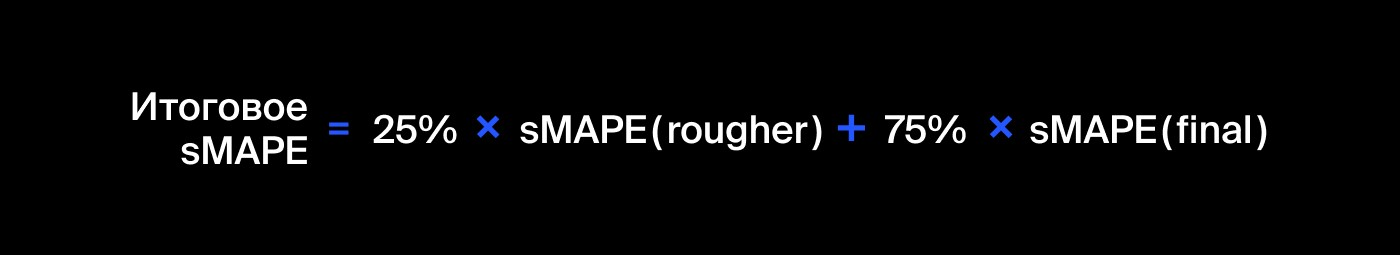

In [25]:
print ('Итоговое sMAPE:',smape_r * 0.25 + smape_f * 0.75) 

Итоговое sMAPE: 10.613689147991263


Симметричное среднее абсолютное процентное отклонение не велико, поэтому можно сказать, что модель работает хорошо на кроссвалидации.

### Применение модели LinearRegression и проверка кросс-валидацией

Для регрессии подготовим признаки с заполненными пропусками.

In [26]:
features_train_1_1.fillna( method ='ffill', inplace = True)
features_train_2_1.fillna( method ='ffill', inplace = True)

Далее этапы аналогичны блоку 3.2

In [27]:
pd.options.mode.chained_assignment = None

scaler_1_1 = StandardScaler()
scaler_1_1.fit(features_train_1_1)
features_train_1_1 = scaler_1_1.transform(features_train_1_1)

scaler_2_1 = StandardScaler()
scaler_2_1.fit(features_train_2_1)
features_train_2_1 = scaler_2_1.transform(features_train_2_1)

In [28]:
model_1_1 = LinearRegression()
res_1_1 = cross_val_predict(model_1_1, features_train_1_1, target_train_1, cv=5)

In [29]:
df_1_1=pd.DataFrame.from_dict({'Actual':list(target_train_1), 'Forecast':list(res_1_1)})

smape_r_1 = (df_1_1.apply(mape, axis=1).sum() * (1/len(df_1_1))) * 100

print ('sMAPE для эффективности чернового концентрата:',smape_r_1)

sMAPE для эффективности чернового концентрата: 12.99653930705248


In [30]:
model_2_1 = LinearRegression()
res_2_1 = cross_val_predict(model_2_1, features_train_2_1, target_train_2, cv=5)

In [31]:
df_2_1=pd.DataFrame.from_dict({'Actual':list(target_train_2), 'Forecast':list(res_2_1)})

smape_f_1 = (df_2_1.apply(mape, axis=1).sum() * (1/len(df_2_1))) * 100

print ('sMAPE для эффективности финального концентрата:',smape_f_1)

sMAPE для эффективности финального концентрата: 12.230730198532996


In [32]:
print ('Итоговое sMAPE для линейной регрессии:',smape_r_1 * 0.25 + smape_f_1 * 0.75) 

Итоговое sMAPE для линейной регрессии: 12.422182475662867


Для линейной регрессии показатель чуть хуже, но все равно остается приемлемым.

### Проверим модель CatBoostRegressor на тестовой выборке

В первую очередь обучим модель на тренировочных выборках.

In [33]:
model_best_1 = CatBoostRegressor(learning_rate=0.01,verbose=100,early_stopping_rounds=200)
model_best_1.fit(features_train_1, target_train_1)
model_best_2 = CatBoostRegressor(learning_rate=0.01,verbose=100,early_stopping_rounds=200)
model_best_2.fit(features_train_2, target_train_2)

0:	learn: 14.8513187	total: 12.3ms	remaining: 12.3s
100:	learn: 12.6733227	total: 5.71s	remaining: 50.8s
200:	learn: 11.8427781	total: 10.1s	remaining: 40s
300:	learn: 11.3100145	total: 14.5s	remaining: 33.7s
400:	learn: 10.9587593	total: 18.8s	remaining: 28s
500:	learn: 10.6502237	total: 23.3s	remaining: 23.2s
600:	learn: 10.4188409	total: 27.6s	remaining: 18.3s
700:	learn: 10.2082625	total: 33.8s	remaining: 14.4s
800:	learn: 10.0248427	total: 41.6s	remaining: 10.3s
900:	learn: 9.8591202	total: 48.2s	remaining: 5.29s
999:	learn: 9.7037597	total: 54.2s	remaining: 0us
0:	learn: 10.3625657	total: 109ms	remaining: 1m 48s
100:	learn: 8.7290810	total: 8.84s	remaining: 1m 18s
200:	learn: 8.1477536	total: 15.9s	remaining: 1m 3s
300:	learn: 7.8429160	total: 24.3s	remaining: 56.5s
400:	learn: 7.6301464	total: 31.3s	remaining: 46.7s
500:	learn: 7.4689158	total: 37.9s	remaining: 37.8s
600:	learn: 7.3284163	total: 44.7s	remaining: 29.7s
700:	learn: 7.2017282	total: 52.2s	remaining: 22.3s
800:	lear

Предскажем значения на тестовой выборке.

In [34]:
model_best_test_res_1 = model_best_1.predict(features_test_1)
model_best_test_res_2 = model_best_2.predict(features_test_2)

Посчитаем итоговый sMAPE для тестовой выборки.

In [35]:
df_best_1=pd.DataFrame.from_dict({'Actual':list(target_test_1), 'Forecast':list(model_best_test_res_1)})
smape_test_r = (df_best_1.apply(mape, axis=1).sum() * (1/len(df_best_1))) * 100
print ('sMAPE для эффективности обогащения чернового концентрата:',smape_test_r)

sMAPE для эффективности обогащения чернового концентрата: 7.863632514792052


In [36]:
df_best_2=pd.DataFrame.from_dict({'Actual':list(target_test_2), 'Forecast':list(model_best_test_res_2)})
smape_test_f = (df_best_2.apply(mape, axis=1).sum() * (1/len(df_best_2))) * 100
print ('sMAPE для эффективности финального концентрата:',smape_test_f)

sMAPE для эффективности финального концентрата: 9.526045832644773


In [37]:
print ('Итоговое sMAPE на тестовой выборке:',smape_test_r * 0.25 + smape_test_f * 0.75) 

Итоговое sMAPE на тестовой выборке: 9.110442503181591


На тестовой выборке модель CatBoostRegressor показала достаточно хороший результат.

 <a id='5'></a>
## Сравнение лучшей модели с константным предсказанием

В качестве константного предсказания будем брать медианное значение таргета. Проверять будем на обучающей выборке.

In [51]:
df_ch_1=pd.DataFrame.from_dict({'Actual':list(target_train_1), 'Forecast':list(ser_1)})

smape_rr = (df_ch_1.apply(mape, axis=1).sum() * (1/len(df_ch_1))) * 100

print ('sMAPE для эффективности чернового концентрата:',smape_rr)

sMAPE для эффективности чернового концентрата: 11.680077060520514


In [52]:
df_ch_2=pd.DataFrame.from_dict({'Actual':list(target_train_2), 'Forecast':list(ser_2)})

smape_ff = (df_ch_2.apply(mape, axis=1).sum() * (1/len(df_ch_2))) * 100

print ('sMAPE для эффективности финального концентрата:',smape_ff)

sMAPE для эффективности финального концентрата: 11.112325869745069


In [54]:
print ('Итоговое sMAPE на обучающей выборке для константной модели:',smape_rr * 0.25 + smape_ff * 0.75) 

Итоговое sMAPE на обучающей выборке для константной модели: 11.25426366743893


По результатам можно сказать, что модель CatboostRegressor показала лучший результат, нежели чем константная медианная модель (11.25 против 10.61). Следовательно модель CatboostRegressor вменяема.

 <a id='4'></a>
## Итоговые выводы

На вход было получено три надобра данных с признаками по процессу добычи золота из руды: обучающи, тестовый и полный. Тестовая выборка имела не весь перечень признаков из обучающего набора, поэтому для обучения модели использовались только признаки, которые присутствуют в обоих датасетах.

В проекте использовалась классическая модель Линейной регрессии с учетом заполнения пропусков и модель CatBoostRegressor без заполнения пропусков. На обучающей выборке качество моделей определялось с помощью кросс валидации. Результаты в таблице.

| Модель | Итоговый sMAPE |
| --- | --- |
| CatBoostRegressor | 10.61 |
| Линейная регрессия | 12.42 |

На основе этих результатов было принято решение использовать модель CatBoostRegressor для тестового набора. Для проверки тестовой модели были подтянуты таргеты из полного набора данных. Итоговый sMAPE составил 9.11.
Показатель sMAPE характеризует cимметричную среднюю абсолютную процентную ошибку. Ошибка в 9 процентов говорит о достаточно хорошей предсказательной способности модели.

Для того, чтобы принять решение какую модель использовть на продуктиве необходимо взвесить все за и против каждой из предложенных моделей.

Плюсы и минусы CatBoostRegressor:
- (+) нет необходимости заполнять пропуски
- (+) итоговый sMAPE лучше Линейной регрессии
- (-) длительное обучение модели

Плюсы и минусы Линейной регрессии:
- (+) быстрое обучение
- (-) необходимо заполнить пропуски
- (-) итоговый sMAPE незначительно хуже CatBoostRegressor